In [1]:
import pandas as pd

# Replace 'your_file.xlsx' with the path to your file
input_file = 'box.xlsx'

# Load the Excel file and skip the first {skiprows} rows
data1 = pd.read_excel(input_file, skiprows=4417)


# Select the 'profit' column (assumed to be 'Unnamed: 10') and filter rows as per your instructions
profit_data = data1["Profit"][1:-1] 
profit_data = profit_data[profit_data.index % 2 == 0]  # Filter for rows with odd indices
profit_data = profit_data.reset_index(drop=True)  # Reset index
# Convert to float, then apply the condition to set values to 1 if > 0, otherwise to 0
profit_data = pd.to_numeric(profit_data, errors='coerce').fillna(0)  # Convert to float, replacing NaN with 0
profit_data = profit_data.apply(lambda x: 1 if x > 0 else 0)  # Apply condition

# Load the CSV file with semicolon separator
file_path = 'box.csv'
data2 = pd.read_csv(file_path, sep=';')

# Drop rows with any missing or incomplete values
data2.dropna(inplace=True)

# Drop any duplicate rows if present
data2.drop_duplicates(inplace=True)

# Convert non-numeric columns to numerical format
for col in data2.columns:
    if data2[col].dtype == 'object':
        # Convert categorical to numerical using label encoding
        data2[col] = data2[col].astype('category').cat.codes

# Ensure all remaining columns are numeric and cleanly formatted for CatBoost
data2 = data2.apply(pd.to_numeric, errors='coerce')
data2.dropna(inplace=True)  # Drop any rows that might still contain NaNs after conversion


# Merge the two DataFrames on the index
merged_data = pd.merge(profit_data, data2, left_index=True, right_index=True, how='inner')

# Save the merged data to a new CSV file
output_csv_path = 'merged_data.csv'
merged_data.to_csv(output_csv_path)

print(f"Merged data saved to {output_csv_path}")

/opt/anaconda3/envs/quant/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Merged data saved to merged_data.csv


In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
data = pd.read_csv("merged_data.csv",index_col=0)

XX = data.drop(columns=['Profit'])
yy = data['Profit']
y = yy.values
X = XX.values
pd.DataFrame(X,y)

0      1     2      3     4      5     6      7     8     9      10  \
1   15.53  12.07  0.60  57.42  0.08  62.39  0.14   2.72  0.89 -0.38   0.07   
1   41.43  24.92  0.81  75.36  0.29  87.12  1.10   5.57  0.27 -0.11   0.74   
0   34.44  25.45  0.11  29.33 -0.18  14.79 -4.17   5.92  0.30 -0.98  -8.07   
1   45.17  33.60  0.12  27.34 -0.14  16.75 -2.53  10.16 -1.36  0.26 -12.05   
1   38.55  30.49  0.86  68.37  0.41  84.96  0.57   7.32  2.19  0.03   0.01   
..    ...    ...   ...    ...   ...    ...   ...    ...   ...   ...    ...   
1   47.70  23.15  0.87  75.14  0.38  91.77  1.37   4.67  0.10  0.95   1.24   
0   32.42  29.23  0.17  34.54 -0.14  15.65 -0.88   7.27  0.09 -0.58  -7.49   
0   53.24  27.22  0.94  71.07  0.33  93.54  0.85   4.11 -0.12  0.30   0.69   
1   57.43  32.76  0.12  24.82 -0.45   8.13 -1.45   4.13  0.02 -1.29  -5.16   
0   27.08  27.35  0.37  35.87  0.06  13.57 -0.93   4.13  0.21 -1.13  -4.65   

      11  
1   2.79  
1   6.32  
0  -2.16  
1  -1.89  
1   7.33  
..   ...  
1   5.91  
0  -0.22  
0   4.80  
1  -1.03  
0  -0.52  

[2176 rows x 12 columns]

In [ ]:
import numpy as np
import pandas as pd
import warnings
import seaborn as sns
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
import catboost as cb
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

# Identify categorical features
cat_feature_indices = [i for i, col in enumerate(XX.columns) if XX[col].dtype == 'object']

# Train CatBoost classifier
model = cb.CatBoostClassifier(   
    iterations=5000,             # Number of trees (similar to n_estimators)
    learning_rate=0.02,          # Learning rate
    depth=5,                    # Depth of each tree
    l2_leaf_reg=5,
    bagging_temperature=1,
    early_stopping_rounds=50,
    loss_function='Logloss',    # Use 'MultiClass' if it's a multi-class problem
    verbose=1000)
model.fit(X_train, y_train, cat_features=cat_feature_indices)


0:	learn: 0.6928639	total: 2.28ms	remaining: 11.4s
1000:	learn: 0.4711839	total: 860ms	remaining: 3.44s
2000:	learn: 0.3328703	total: 1.67s	remaining: 2.5s
3000:	learn: 0.2417743	total: 2.49s	remaining: 1.66s
4000:	learn: 0.1799474	total: 3.3s	remaining: 824ms
4999:	learn: 0.1369795	total: 4.12s	remaining: 0us


AUC Score: 0.54


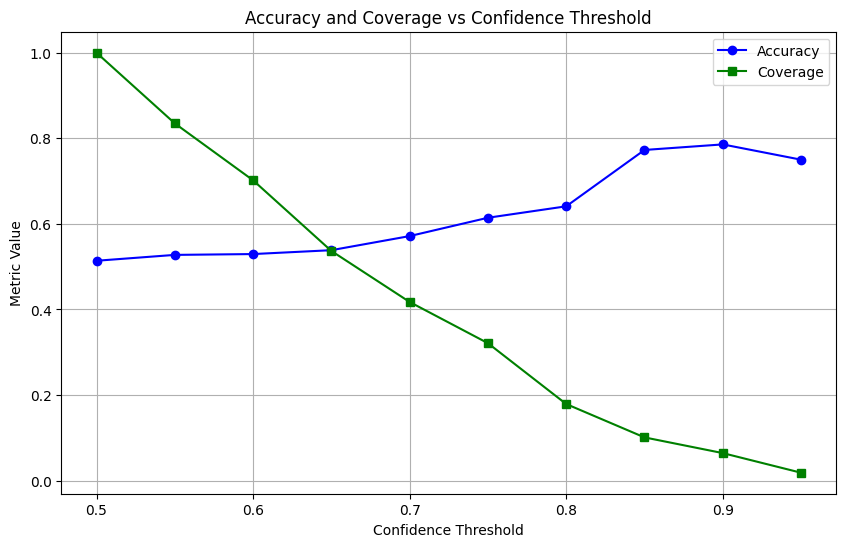

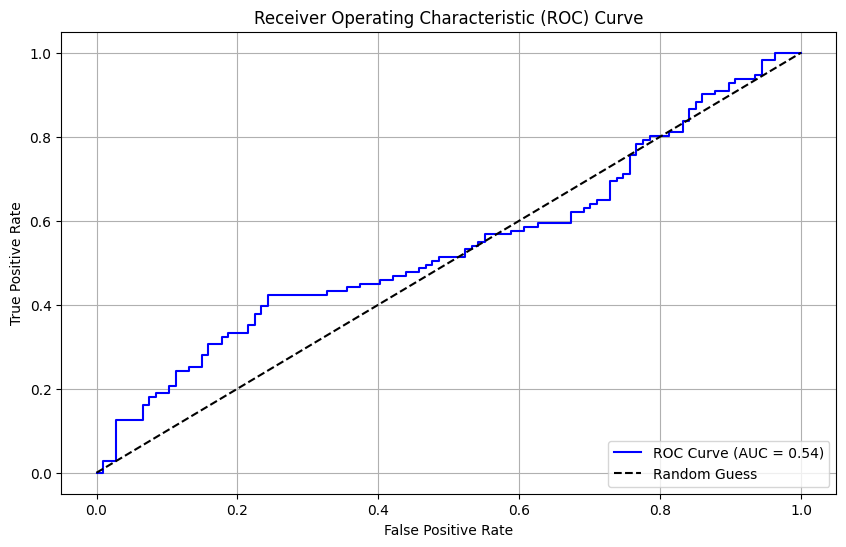

In [5]:
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Assuming you already have y_test, X_test, and model defined
# Predict probabilities
y_prob = model.predict_proba(X_test)[:, 1]  # Probability for positive class

# Compute ROC curve and AUC (for reference)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)
print(f"AUC Score: {auc_score:.2f}")

# Define confidence thresholds to test (e.g., 50%, 60%, 70%, etc.)
confidence_thresholds = np.arange(0.5, 1.0, 0.05)  # From 50% to 95% in steps of 5%
accuracies = []
coverage = []  # Fraction of samples classified at each threshold

for thresh in confidence_thresholds:
    # Classify only when probability is >= thresh (positive) or <= (1 - thresh) (negative)
    y_pred_confident = np.where(y_prob >= thresh, 1, np.where(y_prob <= (1 - thresh), 0, -1))
    
    # Filter out unclassified samples (where y_pred_confident == -1)
    mask = y_pred_confident != -1
    y_test_confident = y_test[mask]
    y_pred_confident = y_pred_confident[mask]
    
    # Calculate accuracy and coverage
    if len(y_test_confident) > 0:  # Avoid division by zero
        acc = np.mean(y_pred_confident == y_test_confident)
        cov = len(y_test_confident) / len(y_test)
    else:
        acc = 0
        cov = 0
    
    accuracies.append(acc)
    coverage.append(cov)

# Plot Accuracy vs Confidence Threshold
plt.figure(figsize=(10, 6))
plt.plot(confidence_thresholds, accuracies, marker='o', label='Accuracy', color='blue')
plt.plot(confidence_thresholds, coverage, marker='s', label='Coverage', color='green')
plt.xlabel('Confidence Threshold')
plt.ylabel('Metric Value')
plt.title('Accuracy and Coverage vs Confidence Threshold')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Also show the original ROC curve for reference
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Feature Importances:
                                              feature  importance
1   Average Directional Movement Index by Welles W...   10.895941
9                                         Stationary3    9.891631
8                                         Stationary2    9.546239
0                  Average Directional Movement Index    8.939460
7                                            Box Size    8.425988
3                             Relative Strength Index    8.119971
6                                          Stationary    7.926497
5                               Stochastic Oscillator    7.808214
4                                Relative Vigor Index    7.648964
2                                            DeMarker    7.406923
10                                      Distance High    7.021133
11                                       Distance Low    6.369038


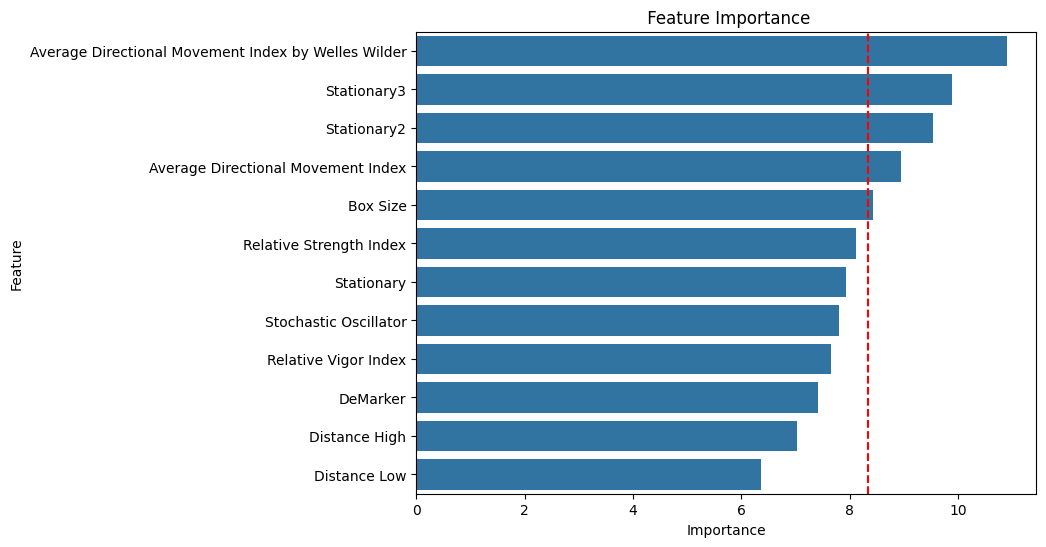

In [7]:
# Feature importance
feature_importance = model.get_feature_importance()
importance_df = pd.DataFrame({
    'feature': XX.columns,
    'importance': feature_importance
}).sort_values('importance', ascending=False)
print("Feature Importances:")
print(importance_df)
plt.figure(figsize=(8, 6))
sns.barplot(x='importance', y='feature', data=importance_df)
plt.title(' Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
x = 100/len(XX.columns)
plt.axvline(x,color = 'red', linestyle = '--')
plt.show()

In [49]:
from onnx.helper import get_attribute_value
import onnxruntime as rt
from skl2onnx import convert_sklearn, update_registered_converter
from skl2onnx.common.shape_calculator import (
    calculate_linear_classifier_output_shapes,
)  # noqa
from skl2onnx.common.data_types import (
    FloatTensorType,
    Int64TensorType,
    guess_tensor_type,
)
from skl2onnx._parse import _apply_zipmap, _get_sklearn_operator_name
from catboost import CatBoostClassifier
from catboost.utils import convert_to_onnx_object

def skl2onnx_parser_castboost_classifier(scope, model, inputs, custom_parsers=None):
    
    options = scope.get_options(model, dict(zipmap=True))
    no_zipmap = isinstance(options["zipmap"], bool) and not options["zipmap"]

    alias = _get_sklearn_operator_name(type(model))
    this_operator = scope.declare_local_operator(alias, model)
    this_operator.inputs = inputs

    label_variable = scope.declare_local_variable("label", Int64TensorType())
    prob_dtype = guess_tensor_type(inputs[0].type)
    probability_tensor_variable = scope.declare_local_variable(
        "probabilities", prob_dtype
    )
    this_operator.outputs.append(label_variable)
    this_operator.outputs.append(probability_tensor_variable)
    probability_tensor = this_operator.outputs

    if no_zipmap:
        return probability_tensor

    return _apply_zipmap(
        options["zipmap"], scope, model, inputs[0].type, probability_tensor
    )


def skl2onnx_convert_catboost(scope, operator, container):
    """
    CatBoost returns an ONNX graph with a single node.
    This function adds it to the main graph.
    """
    onx = convert_to_onnx_object(operator.raw_operator)
    opsets = {d.domain: d.version for d in onx.opset_import}
    if "" in opsets and opsets[""] >= container.target_opset:
        raise RuntimeError("CatBoost uses an opset more recent than the target one.")
    if len(onx.graph.initializer) > 0 or len(onx.graph.sparse_initializer) > 0:
        raise NotImplementedError(
            "CatBoost returns a model initializers. This option is not implemented yet."
        )
    if (
        len(onx.graph.node) not in (1, 2)
        or not onx.graph.node[0].op_type.startswith("TreeEnsemble")
        or (len(onx.graph.node) == 2 and onx.graph.node[1].op_type != "ZipMap")
    ):
        types = ", ".join(map(lambda n: n.op_type, onx.graph.node))
        raise NotImplementedError(
            f"CatBoost returns {len(onx.graph.node)} != 1 (types={types}). "
            f"This option is not implemented yet."
        )
    node = onx.graph.node[0]
    atts = {}
    for att in node.attribute:
        atts[att.name] = get_attribute_value(att)
    container.add_node(
        node.op_type,
        [operator.inputs[0].full_name],
        [operator.outputs[0].full_name, operator.outputs[1].full_name],
        op_domain=node.domain,
        op_version=opsets.get(node.domain, None),
        **atts,
    )


update_registered_converter(
    CatBoostClassifier,
    "CatBoostCatBoostClassifier",
    calculate_linear_classifier_output_shapes,
    skl2onnx_convert_catboost,
    parser=skl2onnx_parser_castboost_classifier,
    options={"nocl": [True, False], "zipmap": [True, False, "columns"]},
)

In [50]:
model_onnx = convert_sklearn(
    model,
    "catboost",
    [("input", FloatTensorType([None, X.shape[1]]))],
    target_opset={"": 12, "ai.onnx.ml": 2},
)

# And save.
with open("box2024.onnx", "wb") as f:
    f.write(model_onnx.SerializeToString())